In [76]:
import os
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_squared_error, roc_auc_score, accuracy_score

import lightgbm as lgb
from lightgbm import LGBMClassifier

import optuna

In [116]:
N_THREADS = 8 # threads cnt for lgbm and linear models
N_FOLDS = 5 # folds cnt for AutoML
RANDOM_STATE = 30 # fixed random state for various reasons
TEST_SIZE = 0.2 # Test size for metric check
TARGET_NAME = 'TARGET' # Target column name

In [117]:
DATASET_DIR = './test_data_files'
DATASET_NAME = 'sampled_app_train.csv'
DATASET_FULLNAME = os.path.join(DATASET_DIR, DATASET_NAME)

In [118]:
data = pd.read_csv(DATASET_FULLNAME)
data.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,313802,0,Cash loans,M,N,Y,0,270000.0,327024.0,15372.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,319656,0,Cash loans,F,N,N,0,108000.0,675000.0,19737.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,207678,0,Revolving loans,F,Y,Y,2,112500.0,270000.0,13500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
3,381593,0,Cash loans,F,N,N,1,67500.0,142200.0,9630.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,4.0
4,258153,0,Cash loans,F,Y,Y,0,337500.0,1483231.5,46570.5,...,0,0,0,0,0.0,0.0,0.0,2.0,0.0,0.0


In [119]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 9.3+ MB


In [120]:
data['BIRTH_DATE'] = (np.datetime64('2018-01-01') + data['DAYS_BIRTH'].astype(np.dtype('timedelta64[D]'))).astype(str)
data['EMP_DATE'] = (np.datetime64('2018-01-01') + np.clip(data['DAYS_EMPLOYED'], None, 0).astype(np.dtype('timedelta64[D]'))
                    ).astype(str)

data['constant'] = 1
data['allnan'] = np.nan

data['report_dt'] = np.datetime64('2018-01-01')

data.drop(['DAYS_BIRTH', 'DAYS_EMPLOYED'], axis=1, inplace=True)

![AutoML pipeline for this task](tutorial_1_pipeline.png)

### SimpleFeatures for TreeBasedModel

- Numeric stay as is, Datetime transforms to numeric.
- Categorical label encoding.
- Maps input to output features exactly one-to-one.

In [121]:
numerical_columns = data._get_numeric_data().columns
date_columns = ['BIRTH_DATE', 'EMP_DATE']
categorycal_columns = list(set(data.columns) - set(numerical_columns) - set(date_columns))

In [122]:
df = data.copy()

In [123]:
data.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,BIRTH_DATE,EMP_DATE,constant,allnan,report_dt
0,313802,0,Cash loans,M,N,Y,0,270000.0,327024.0,15372.0,...,0.0,0.0,0.0,0.0,1.0,1967-02-08,2017-05-20,1,NaN,2018-01-01
1,319656,0,Cash loans,F,N,N,0,108000.0,675000.0,19737.0,...,0.0,0.0,0.0,0.0,0.0,1962-05-19,2007-07-16,1,NaN,2018-01-01
2,207678,0,Revolving loans,F,Y,Y,2,112500.0,270000.0,13500.0,...,0.0,0.0,0.0,0.0,1.0,1991-11-14,2015-01-21,1,NaN,2018-01-01
3,381593,0,Cash loans,F,N,N,1,67500.0,142200.0,9630.0,...,0.0,0.0,0.0,0.0,4.0,1986-09-25,2011-10-13,1,NaN,2018-01-01
4,258153,0,Cash loans,F,Y,Y,0,337500.0,1483231.5,46570.5,...,0.0,0.0,2.0,0.0,0.0,1981-11-08,2013-02-21,1,NaN,2018-01-01


#### LavelEncoding

In [124]:
for cat_col in categorycal_columns:
    le = LabelEncoder()
    df[cat_col] = le.fit_transform(df[cat_col])

In [125]:
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,BIRTH_DATE,EMP_DATE,constant,allnan,report_dt
0,313802,0,0,1,0,1,0,270000.0,327024.0,15372.0,...,0.0,0.0,0.0,0.0,1.0,1967-02-08,2017-05-20,1,NaN,0
1,319656,0,0,0,0,0,0,108000.0,675000.0,19737.0,...,0.0,0.0,0.0,0.0,0.0,1962-05-19,2007-07-16,1,NaN,0
2,207678,0,1,0,1,1,2,112500.0,270000.0,13500.0,...,0.0,0.0,0.0,0.0,1.0,1991-11-14,2015-01-21,1,NaN,0
3,381593,0,0,0,0,0,1,67500.0,142200.0,9630.0,...,0.0,0.0,0.0,0.0,4.0,1986-09-25,2011-10-13,1,NaN,0
4,258153,0,0,0,1,1,0,337500.0,1483231.5,46570.5,...,0.0,0.0,2.0,0.0,0.0,1981-11-08,2013-02-21,1,NaN,0


#### One-Hot-Encoding

In [126]:
for cat_col in categorycal_columns:
    le = OneHotEncoder(handle_unknown='error', drop='if_binary')
    a = le.fit_transform(df[[cat_col]]).toarray()
    shift = df.columns[-1]
    if not isinstance(shift, int):
        shift = 0
    end_col = pd.DataFrame(data=a, columns=np.arange(a.shape[1]) + shift + 1)
    df = df.join(end_col)
    df.drop(axis=1, inplace=True, columns=[cat_col])

In [127]:
df.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,129,130,131,132,133,134,135,136,137,138
0,313802,0,0,270000.0,327024.0,15372.0,270000.0,0.072508,-2432.0,-2137,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,319656,0,0,108000.0,675000.0,19737.0,675000.0,0.035792,-13156.0,-3758,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,207678,0,2,112500.0,270000.0,13500.0,270000.0,0.031329,-4077.0,-1058,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,381593,0,1,67500.0,142200.0,9630.0,112500.0,0.008474,-5106.0,-1556,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
4,258153,0,0,337500.0,1483231.5,46570.5,1354500.0,0.008474,-5743.0,-4256,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


#### Datetime to numeric

In [128]:
basic_time = '2020-01-01'
basic_interval = 'D'

for date_col in date_columns:
    df[date_col] = pd.to_datetime(df[date_col])
    df[date_col] = ((df[date_col] - np.datetime64(basic_time)) / np.timedelta64(1, basic_interval)).values.astype(np.float32)

# ------------------------------

### ImportanceBasedFeatureSelector

In [129]:
train_labels = df['TARGET']
df.drop(columns=['TARGET'], axis=1, inplace=True)
train = df
num_feats = len(train.columns)

In [130]:
lgbc=LGBMClassifier(learning_rate=0.05, num_leaves=64)

embeded_lgb_selector = SelectFromModel(lgbc, max_features=num_feats)
embeded_lgb_selector.fit(train, train_labels)

embeded_lgb_support = embeded_lgb_selector.get_support()
embeded_lgb_feature = train.loc[:,embeded_lgb_support].columns.tolist()
print(str(len(embeded_lgb_feature)), 'selected features')

51 selected features


In [131]:
df = df[embeded_lgb_feature]
df.head()

,SK_ID_CURR,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,CNT_FAM_MEMBERS,...,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,BIRTH_DATE,EMP_DATE,29,41,91,102,119,131
0,313802,270000.0,327024.0,15372.0,270000.0,0.072508,-2432.0,-2137,NaN,2.0,...,0.0,1.0,-19320.0,-956.0,0.0,1.0,0.0,1.0,0.0,1.0
1,319656,108000.0,675000.0,19737.0,675000.0,0.035792,-13156.0,-3758,NaN,2.0,...,0.0,0.0,-21046.0,-4552.0,0.0,1.0,0.0,0.0,1.0,1.0
2,207678,112500.0,270000.0,13500.0,270000.0,0.031329,-4077.0,-1058,18.0,4.0,...,0.0,1.0,-10275.0,-1806.0,1.0,1.0,0.0,0.0,0.0,1.0
3,381593,67500.0,142200.0,9630.0,112500.0,0.008474,-5106.0,-1556,NaN,3.0,...,0.0,4.0,-12151.0,-3002.0,0.0,1.0,0.0,0.0,0.0,1.0
4,258153,337500.0,1483231.5,46570.5,1354500.0,0.008474,-5743.0,-4256,9.0,2.0,...,0.0,0.0,-13933.0,-2505.0,0.0,1.0,0.0,0.0,0.0,1.0


#### First level models

In [132]:
train_features, test_features, train_target, test_target = train_test_split(df, train_labels, test_size=TEST_SIZE, random_state=RANDOM_STATE)
train_full_features, test_full_features = train_test_split(train, test_size=TEST_SIZE, random_state=RANDOM_STATE)
train_features

,SK_ID_CURR,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,CNT_FAM_MEMBERS,...,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,BIRTH_DATE,EMP_DATE,29,41,91,102,119,131
2182,315992,180000.0,545040.0,25537.5,450000.0,0.003069,-2344.0,-551,NaN,2.0,...,0.0,3.0,-16552.0,-730.0,0.0,1.0,0.0,0.0,0.0,0.0
5766,284326,130500.0,900000.0,38133.0,900000.0,0.003069,-5122.0,-690,NaN,3.0,...,0.0,1.0,-12278.0,-3554.0,0.0,1.0,0.0,0.0,1.0,0.0
2439,155276,382500.0,1532565.0,65061.0,1323000.0,0.020713,-10348.0,-4291,NaN,2.0,...,1.0,1.0,-17139.0,-3486.0,0.0,1.0,0.0,0.0,0.0,0.0
993,419231,85500.0,1288350.0,37800.0,1125000.0,0.003813,-4109.0,-4522,NaN,2.0,...,1.0,2.0,-22250.0,-730.0,0.0,1.0,0.0,0.0,0.0,0.0
7426,289793,67500.0,659610.0,25686.0,472500.0,0.020246,-881.0,-4432,NaN,2.0,...,0.0,2.0,-22359.0,-730.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4859,395317,180000.0,227520.0,8707.5,180000.0,0.018801,-859.0,-817,15.0,2.0,...,0.0,2.0,-18015.0,-1064.0,0.0,1.0,0.0,0.0,0.0,0.0
919,287864,202500.0,270000.0,13500.0,270000.0,0.028663,-2184.0,-2184,3.0,2.0,...,0.0,4.0,-10749.0,-1926.0,0.0,1.0,0.0,1.0,1.0,0.0
500,101371,315000.0,1024636.5,33993.0,918000.0,0.035792,-6085.0,-1974,NaN,3.0,...,0.0,2.0,-19191.0,-1562.0,0.0,1.0,0.0,1.0,0.0,0.0
4517,275047,120339.0,1035000.0,28593.0,1035000.0,0.030755,-3982.0,-4281,NaN,3.0,...,0.0,1.0,-14204.0,-1398.0,0.0,0.0,0.0,1.0,0.0,0.0


In [133]:
default_params = {
    'task': 'train',
    "learning_rate": 0.01,
    "num_leaves": 24,
    "feature_fraction": 0.7,
    "bagging_fraction": 0.7,
    'bagging_freq': 1,
    "max_depth": -1,
    "verbosity": -1,
    "reg_alpha": 0.5,
    "reg_lambda": 0.0,
    "min_split_gain": 0.0,
    'zero_as_missing': False,
    'num_threads': 4,
    'max_bin': 255,
    'min_data_in_bin': 3,
    'num_trees': 3000,
    'random_state': 42,
    'early_stopping_rounds': 200
}
# **default_params
lgbc=LGBMClassifier(**default_params)
lgbc.fit(train_features, train_target, eval_set=(test_features, test_target), eval_metric = 'auc')
LGBM_predicted_train = lgbc.predict_proba(train_features)
LGBM_predicted_test = lgbc.predict_proba(test_features)

[1]	valid_0's auc: 0.663553	valid_0's binary_logloss: 0.272233
Training until validation scores don't improve for 200 rounds
[2]	valid_0's auc: 0.67162	valid_0's binary_logloss: 0.271883
[3]	valid_0's auc: 0.677531	valid_0's binary_logloss: 0.271495
[4]	valid_0's auc: 0.682374	valid_0's binary_logloss: 0.27115
[5]	valid_0's auc: 0.683985	valid_0's binary_logloss: 0.270604
[6]	valid_0's auc: 0.688464	valid_0's binary_logloss: 0.270174
[7]	valid_0's auc: 0.689013	valid_0's binary_logloss: 0.269769
[8]	valid_0's auc: 0.694298	valid_0's binary_logloss: 0.269431
[9]	valid_0's auc: 0.692134	valid_0's binary_logloss: 0.269187
[10]	valid_0's auc: 0.69409	valid_0's binary_logloss: 0.268747
[11]	valid_0's auc: 0.697619	valid_0's binary_logloss: 0.268266
[12]	valid_0's auc: 0.697619	valid_0's binary_logloss: 0.267934
[13]	valid_0's auc: 0.698278	valid_0's binary_logloss: 0.26766
[14]	valid_0's auc: 0.700745	valid_0's binary_logloss: 0.267489
[15]	valid_0's auc: 0.699414	valid_0's binary_logloss: 

/home/magleb/.local/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/magleb/.local/lib/python3.8/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[22]	valid_0's auc: 0.701425	valid_0's binary_logloss: 0.265071
[23]	valid_0's auc: 0.700467	valid_0's binary_logloss: 0.264858
[24]	valid_0's auc: 0.702628	valid_0's binary_logloss: 0.264526
[25]	valid_0's auc: 0.703457	valid_0's binary_logloss: 0.264222
[26]	valid_0's auc: 0.70905	valid_0's binary_logloss: 0.26393
[27]	valid_0's auc: 0.712506	valid_0's binary_logloss: 0.263569
[28]	valid_0's auc: 0.71315	valid_0's binary_logloss: 0.263384
[29]	valid_0's auc: 0.713178	valid_0's binary_logloss: 0.263198
[30]	valid_0's auc: 0.713456	valid_0's binary_logloss: 0.262855
[31]	valid_0's auc: 0.711546	valid_0's binary_logloss: 0.2627
[32]	valid_0's auc: 0.711242	valid_0's binary_logloss: 0.262519
[33]	valid_0's auc: 0.714167	valid_0's binary_logloss: 0.26224
[34]	valid_0's auc: 0.714153	valid_0's binary_logloss: 0.262088
[35]	valid_0's auc: 0.71443	valid_0's binary_logloss: 0.261937
[36]	valid_0's auc: 0.714256	valid_0's binary_logloss: 0.261828
[37]	valid_0's auc: 0.713837	valid_0's binary_l

In [134]:
def objective(trial):
    
    train_fea, valid_fea, train_tar, valid_tar = train_test_split(train_features, train_target, test_size=0.2, random_state=42)
    
    dtrain = lgb.Dataset(train_fea, label = train_tar, free_raw_data = False)
    dtest  = lgb.Dataset(test_features, label = test_target, free_raw_data = False)
    dvalid  = lgb.Dataset(valid_fea, label = valid_tar, free_raw_data = False)
    
    param = {
        'task': 'train',
        "learning_rate": 0.01,
        'bagging_freq': 1,
        "max_depth": -1,
        "verbosity": -1,
        "reg_alpha": 0.5,
        "reg_lambda": 0.0,
        "min_split_gain": 0.0,
        'zero_as_missing': False,
        'num_threads': 4,
        'max_bin': 255,
        'min_data_in_bin': 3,
        'num_trees': 3000,
        'random_state': 42,
        'early_stopping_rounds': 200,
        'num_leaves': trial.suggest_int('num_leaves', 16, 256),
        'metric': 'auc',
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.5, 1.0),
        'min_sum_hessian_in_leaf': trial.suggest_loguniform('min_sum_hessian_in_leaf', 1e-3, 10.0)
    }
    
    # Add a callback for pruning
    pruning_callback = optuna.integration.LightGBMPruningCallback(trial, 'auc')
    
    gbm = lgb.train(
        param, 
        dtrain, 
        verbose_eval = 20,
        valid_sets = [dtest],
        callbacks = [pruning_callback]
        )
    
    preds = gbm.predict(valid_fea)
#     accuracy = np.sqrt(mean_squared_error(test_target, preds))
    accuracy = roc_auc_score(valid_tar, preds)

    return accuracy



study = optuna.create_study(direction = 'maximize', pruner = optuna.pruners.MedianPruner(n_warmup_steps = 10))
study.optimize(objective, n_trials = 100)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    

[I 2021-07-15 13:23:04,459] A new study created in memory with name: no-name-1dfbd5ca-9c81-4060-8690-eda696ef4390


Training until validation scores don't improve for 200 rounds
[20]	valid_0's auc: 0.711293
[40]	valid_0's auc: 0.719259
[60]	valid_0's auc: 0.71537
[80]	valid_0's auc: 0.718982
[100]	valid_0's auc: 0.714321
[120]	valid_0's auc: 0.714982
[140]	valid_0's auc: 0.713706
[160]	valid_0's auc: 0.716671
[180]	valid_0's auc: 0.716594
[200]	valid_0's auc: 0.717346
[220]	valid_0's auc: 0.715709


[I 2021-07-15 13:23:05,960] Trial 0 finished with value: 0.6867041546612138 and parameters: {'num_leaves': 136, 'feature_fraction': 0.7837492060993628, 'bagging_fraction': 0.515249706475084, 'min_sum_hessian_in_leaf': 0.040589600031277887}. Best is trial 0 with value: 0.6867041546612138.


[240]	valid_0's auc: 0.716919
[260]	valid_0's auc: 0.717748
Early stopping, best iteration is:
[74]	valid_0's auc: 0.721108


/home/magleb/.local/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/magleb/.local/lib/python3.8/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds
[20]	valid_0's auc: 0.701163
[40]	valid_0's auc: 0.710747
[60]	valid_0's auc: 0.70827
[80]	valid_0's auc: 0.711034
[100]	valid_0's auc: 0.712618
[120]	valid_0's auc: 0.708457
[140]	valid_0's auc: 0.709366
[160]	valid_0's auc: 0.710803
[180]	valid_0's auc: 0.711398
[200]	valid_0's auc: 0.714597
[220]	valid_0's auc: 0.71352
[240]	valid_0's auc: 0.715014
[260]	valid_0's auc: 0.716944
[280]	valid_0's auc: 0.717105
[300]	valid_0's auc: 0.716835
[320]	valid_0's auc: 0.717007
[340]	valid_0's auc: 0.717598
[360]	valid_0's auc: 0.716818
[380]	valid_0's auc: 0.715042
[400]	valid_0's auc: 0.712667
[420]	valid_0's auc: 0.711482
[440]	valid_0's auc: 0.712783
[460]	valid_0's auc: 0.713381
[480]	valid_0's auc: 0.713013


[I 2021-07-15 13:23:07,213] Trial 1 finished with value: 0.702859234129566 and parameters: {'num_leaves': 24, 'feature_fraction': 0.817582501282925, 'bagging_fraction': 0.5203740344614768, 'min_sum_hessian_in_leaf': 0.0038892424289111672}. Best is trial 1 with value: 0.702859234129566.


[500]	valid_0's auc: 0.713003
[520]	valid_0's auc: 0.713395
Early stopping, best iteration is:
[328]	valid_0's auc: 0.718881
Training until validation scores don't improve for 200 rounds


/home/magleb/.local/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/magleb/.local/lib/python3.8/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	valid_0's auc: 0.703464
[40]	valid_0's auc: 0.710108
[60]	valid_0's auc: 0.710712
[80]	valid_0's auc: 0.710272
[100]	valid_0's auc: 0.709513
[120]	valid_0's auc: 0.710226
[140]	valid_0's auc: 0.711741
[160]	valid_0's auc: 0.712468
[180]	valid_0's auc: 0.712118
[200]	valid_0's auc: 0.714961
[220]	valid_0's auc: 0.714545
[240]	valid_0's auc: 0.717171
[260]	valid_0's auc: 0.718119
[280]	valid_0's auc: 0.718391
[300]	valid_0's auc: 0.71715
[320]	valid_0's auc: 0.716647
[340]	valid_0's auc: 0.716115
[360]	valid_0's auc: 0.713734
[380]	valid_0's auc: 0.713395
[400]	valid_0's auc: 0.713122
[420]	valid_0's auc: 0.711541
[440]	valid_0's auc: 0.710296
[460]	valid_0's auc: 0.708761
Early stopping, best iteration is:
[279]	valid_0's auc: 0.718626


[I 2021-07-15 13:23:10,395] Trial 2 finished with value: 0.6841772004833162 and parameters: {'num_leaves': 137, 'feature_fraction': 0.8961917999252501, 'bagging_fraction': 0.6151852408239966, 'min_sum_hessian_in_leaf': 0.2000169611638482}. Best is trial 1 with value: 0.702859234129566.
/home/magleb/.local/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/magleb/.local/lib/python3.8/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds
[20]	valid_0's auc: 0.705523
[40]	valid_0's auc: 0.711912
[60]	valid_0's auc: 0.713961
[80]	valid_0's auc: 0.719549
[100]	valid_0's auc: 0.721171
[120]	valid_0's auc: 0.719133
[140]	valid_0's auc: 0.716846
[160]	valid_0's auc: 0.716779
[180]	valid_0's auc: 0.719493
[200]	valid_0's auc: 0.719811
[220]	valid_0's auc: 0.721325
[240]	valid_0's auc: 0.720629
[260]	valid_0's auc: 0.722783
[280]	valid_0's auc: 0.723039


[I 2021-07-15 13:23:11,723] Trial 3 finished with value: 0.6847174458592805 and parameters: {'num_leaves': 69, 'feature_fraction': 0.6048560609308598, 'bagging_fraction': 0.6056059821958459, 'min_sum_hessian_in_leaf': 0.02543324778844792}. Best is trial 1 with value: 0.702859234129566.


Early stopping, best iteration is:
[91]	valid_0's auc: 0.724004
Training until validation scores don't improve for 200 rounds
[20]	valid_0's auc: 0.697215


/home/magleb/.local/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/magleb/.local/lib/python3.8/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[40]	valid_0's auc: 0.705852
[60]	valid_0's auc: 0.705313
[80]	valid_0's auc: 0.709212
[100]	valid_0's auc: 0.711398
[120]	valid_0's auc: 0.71151
[140]	valid_0's auc: 0.711293
[160]	valid_0's auc: 0.712615
[180]	valid_0's auc: 0.712464
[200]	valid_0's auc: 0.711615
[220]	valid_0's auc: 0.709828
[240]	valid_0's auc: 0.710583
[260]	valid_0's auc: 0.710513
[280]	valid_0's auc: 0.709017
[300]	valid_0's auc: 0.708286
[320]	valid_0's auc: 0.70502
[340]	valid_0's auc: 0.704964


[I 2021-07-15 13:23:14,186] Trial 4 finished with value: 0.6956617715401059 and parameters: {'num_leaves': 214, 'feature_fraction': 0.7402865293456133, 'bagging_fraction': 0.7392294916022062, 'min_sum_hessian_in_leaf': 0.9239491654361944}. Best is trial 1 with value: 0.702859234129566.


[360]	valid_0's auc: 0.704387
Early stopping, best iteration is:
[169]	valid_0's auc: 0.71444
Training until validation scores don't improve for 200 rounds


/home/magleb/.local/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/magleb/.local/lib/python3.8/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
[I 2021-07-15 13:23:14,273] Trial 5 pruned. Trial was pruned at iteration 11.
[I 2021-07-15 13:23:14,351] Trial 6 pruned. Trial was pruned at iteration 10.
[I 2021-07-15 13:23:14,478] Trial 7 pruned. Trial was pruned at iteration 29.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
[20]	valid_0's auc: 0.705049
Training until validation scores don't improve for 200 rounds
[20]	valid_0's auc: 0.712908
[40]	valid_0's auc: 0.719934
[60]	valid_0's auc: 0.721647
[80]	valid_0's auc: 0.719073
[100]	valid_0's auc: 0.716363
[120]	valid_0's auc: 0.715181
[140]	valid_0's auc: 0.71472
[160]	valid_0's auc: 0.714374
[180]	valid_0's auc: 0.713853
[200]	valid_0's auc: 0.712908
[220]	valid_0's auc: 0.710912


[I 2021-07-15 13:23:16,279] Trial 8 finished with value: 0.6874012454689098 and parameters: {'num_leaves': 193, 'feature_fraction': 0.7983810645168279, 'bagging_fraction': 0.7909290232832364, 'min_sum_hessian_in_leaf': 0.026054939744929364}. Best is trial 1 with value: 0.702859234129566.


[240]	valid_0's auc: 0.709024
Early stopping, best iteration is:
[47]	valid_0's auc: 0.72336
Training until validation scores don't improve for 200 rounds
[20]	valid_0's auc: 0.706639


/home/magleb/.local/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/magleb/.local/lib/python3.8/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[40]	valid_0's auc: 0.708807
[60]	valid_0's auc: 0.703806
[80]	valid_0's auc: 0.707244
[100]	valid_0's auc: 0.705222
[120]	valid_0's auc: 0.706125
[140]	valid_0's auc: 0.707359
[160]	valid_0's auc: 0.710191
[180]	valid_0's auc: 0.709076
[200]	valid_0's auc: 0.708922


[I 2021-07-15 13:23:17,308] Trial 9 finished with value: 0.6351281485268148 and parameters: {'num_leaves': 236, 'feature_fraction': 0.7213696624929316, 'bagging_fraction': 0.5152483151794973, 'min_sum_hessian_in_leaf': 1.580409021965545}. Best is trial 1 with value: 0.702859234129566.
/home/magleb/.local/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/magleb/.local/lib/python3.8/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
[I 2021-07-15 13:23:17,400] Trial 10 pruned. Trial was pruned at iteration 10.


Early stopping, best iteration is:
[8]	valid_0's auc: 0.721525
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
[20]	valid_0's auc: 0.711338
[40]	valid_0's auc: 0.716786
[60]	valid_0's auc: 0.712055
[80]	valid_0's auc: 0.708135
[100]	valid_0's auc: 0.706128
[120]	valid_0's auc: 0.70375
[140]	valid_0's auc: 0.701152
[160]	valid_0's auc: 0.699537
[180]	valid_0's auc: 0.699477
[200]	valid_0's auc: 0.701925


[I 2021-07-15 13:23:19,225] Trial 11 finished with value: 0.6569209499024072 and parameters: {'num_leaves': 255, 'feature_fraction': 0.6919851844313625, 'bagging_fraction': 0.9916522483472168, 'min_sum_hessian_in_leaf': 7.743935014933286}. Best is trial 1 with value: 0.702859234129566.


[220]	valid_0's auc: 0.702355
Early stopping, best iteration is:
[29]	valid_0's auc: 0.71878
Training until validation scores don't improve for 200 rounds


/home/magleb/.local/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/magleb/.local/lib/python3.8/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
[I 2021-07-15 13:23:19,340] Trial 12 pruned. Trial was pruned at iteration 10.
[I 2021-07-15 13:23:19,449] Trial 13 pruned. Trial was pruned at iteration 10.
[I 2021-07-15 13:23:19,528] Trial 14 pruned. Trial was pruned at iteration 10.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds


[I 2021-07-15 13:23:19,598] Trial 15 pruned. Trial was pruned at iteration 10.


Training until validation scores don't improve for 200 rounds
[20]	valid_0's auc: 0.708062


[I 2021-07-15 13:23:19,884] Trial 16 pruned. Trial was pruned at iteration 30.
[I 2021-07-15 13:23:19,971] Trial 17 pruned. Trial was pruned at iteration 10.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
[20]	valid_0's auc: 0.704282


[I 2021-07-15 13:23:20,155] Trial 18 pruned. Trial was pruned at iteration 30.
[I 2021-07-15 13:23:20,221] Trial 19 pruned. Trial was pruned at iteration 11.
[I 2021-07-15 13:23:20,335] Trial 20 pruned. Trial was pruned at iteration 10.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
[20]	valid_0's auc: 0.714748
[40]	valid_0's auc: 0.722175
[60]	valid_0's auc: 0.718577
[80]	valid_0's auc: 0.719322
[100]	valid_0's auc: 0.715657
[120]	valid_0's auc: 0.71372
[140]	valid_0's auc: 0.714339
[160]	valid_0's auc: 0.713475
[180]	valid_0's auc: 0.71295
[200]	valid_0's auc: 0.714489
[220]	valid_0's auc: 0.713692
[240]	valid_0's auc: 0.710971


[I 2021-07-15 13:23:22,157] Trial 21 finished with value: 0.6831606097220931 and parameters: {'num_leaves': 200, 'feature_fraction': 0.8075375822159309, 'bagging_fraction': 0.791945451492757, 'min_sum_hessian_in_leaf': 0.010891747635489226}. Best is trial 1 with value: 0.702859234129566.
/home/magleb/.local/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/magleb/.local/lib/python3.8/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
[I 2021-07-15 13:23:22,262] Trial 22 pruned. Trial was pruned at iteration 10.


Early stopping, best iteration is:
[47]	valid_0's auc: 0.723193
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds


[I 2021-07-15 13:23:22,370] Trial 23 pruned. Trial was pruned at iteration 10.
[I 2021-07-15 13:23:22,500] Trial 24 pruned. Trial was pruned at iteration 10.
[I 2021-07-15 13:23:22,622] Trial 25 pruned. Trial was pruned at iteration 10.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds


[I 2021-07-15 13:23:22,787] Trial 26 pruned. Trial was pruned at iteration 10.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds


[I 2021-07-15 13:23:22,916] Trial 27 pruned. Trial was pruned at iteration 10.
[I 2021-07-15 13:23:23,018] Trial 28 pruned. Trial was pruned at iteration 10.
[I 2021-07-15 13:23:23,127] Trial 29 pruned. Trial was pruned at iteration 10.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds


[I 2021-07-15 13:23:23,249] Trial 30 pruned. Trial was pruned at iteration 10.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
[20]	valid_0's auc: 0.705768
[40]	valid_0's auc: 0.709328
[60]	valid_0's auc: 0.713101
[80]	valid_0's auc: 0.711136
[100]	valid_0's auc: 0.710719
[120]	valid_0's auc: 0.713192
[140]	valid_0's auc: 0.713482
[160]	valid_0's auc: 0.715164
[180]	valid_0's auc: 0.712846
[200]	valid_0's auc: 0.713195


[I 2021-07-15 13:23:24,273] Trial 31 finished with value: 0.661120922018775 and parameters: {'num_leaves': 136, 'feature_fraction': 0.8174440041177965, 'bagging_fraction': 0.505193475175558, 'min_sum_hessian_in_leaf': 0.11314236767309696}. Best is trial 1 with value: 0.702859234129566.
/home/magleb/.local/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/magleb/.local/lib/python3.8/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
[I 2021-07-15 13:23:24,363] Trial 32 pruned. Trial was pruned at iteration 10.


Early stopping, best iteration is:
[6]	valid_0's auc: 0.716239
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
[20]	valid_0's auc: 0.708048
[40]	valid_0's auc: 0.705278
[60]	valid_0's auc: 0.7096
[80]	valid_0's auc: 0.712241
[100]	valid_0's auc: 0.714286
[120]	valid_0's auc: 0.715681
[140]	valid_0's auc: 0.715727
[160]	valid_0's auc: 0.716884
[180]	valid_0's auc: 0.716227
[200]	valid_0's auc: 0.716786
[220]	valid_0's auc: 0.717318
[240]	valid_0's auc: 0.717594
[260]	valid_0's auc: 0.714545
[280]	valid_0's auc: 0.714395
[300]	valid_0's auc: 0.712272
[320]	valid_0's auc: 0.714716
[340]	valid_0's auc: 0.712111
[360]	valid_0's auc: 0.712758
[380]	valid_0's auc: 0.711384
Early stopping, best iteration is:
[190]	valid_0's auc: 0.718052


[I 2021-07-15 13:23:26,887] Trial 33 finished with value: 0.6932219537131704 and parameters: {'num_leaves': 81, 'feature_fraction': 0.8598563562612795, 'bagging_fraction': 0.5409484220052688, 'min_sum_hessian_in_leaf': 0.01810525188876901}. Best is trial 1 with value: 0.702859234129566.
/home/magleb/.local/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/magleb/.local/lib/python3.8/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
[I 2021-07-15 13:23:26,977] Trial 34 pruned. Trial was pruned at iteration 10.
[I 2021-07-15 13:23:27,069] Trial 35 pruned. Trial was pruned at iteration 10.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds


[I 2021-07-15 13:23:27,158] Trial 36 pruned. Trial was pruned at iteration 10.
[I 2021-07-15 13:23:27,260] Trial 37 pruned. Trial was pruned at iteration 10.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
[20]	valid_0's auc: 0.70856
[40]	valid_0's auc: 0.716825
[60]	valid_0's auc: 0.716199
[80]	valid_0's auc: 0.71778
[100]	valid_0's auc: 0.717825
[120]	valid_0's auc: 0.717724
[140]	valid_0's auc: 0.717143
[160]	valid_0's auc: 0.71643
[180]	valid_0's auc: 0.716209
[200]	valid_0's auc: 0.716129
[220]	valid_0's auc: 0.715279
[240]	valid_0's auc: 0.715412
[260]	valid_0's auc: 0.714709


[I 2021-07-15 13:23:28,583] Trial 38 finished with value: 0.6869829909842922 and parameters: {'num_leaves': 46, 'feature_fraction': 0.79450611149552, 'bagging_fraction': 0.500660877922895, 'min_sum_hessian_in_leaf': 0.5622574027420617}. Best is trial 1 with value: 0.702859234129566.
/home/magleb/.local/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/magleb/.local/lib/python3.8/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
[I 2021-07-15 13:23:28,692] Trial 39 pruned. Trial was pruned at iteration 10.


[280]	valid_0's auc: 0.715618
Early stopping, best iteration is:
[97]	valid_0's auc: 0.719105
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
[20]	valid_0's auc: 0.711789
[40]	valid_0's auc: 0.70796
[60]	valid_0's auc: 0.712908
[80]	valid_0's auc: 0.715909
[100]	valid_0's auc: 0.714538
[120]	valid_0's auc: 0.715255
[140]	valid_0's auc: 0.713367
[160]	valid_0's auc: 0.713395
[180]	valid_0's auc: 0.711894
[200]	valid_0's auc: 0.715517
[220]	valid_0's auc: 0.715549


[I 2021-07-15 13:23:30,174] Trial 40 pruned. Trial was pruned at iteration 261.


[240]	valid_0's auc: 0.716678
[260]	valid_0's auc: 0.714555
Training until validation scores don't improve for 200 rounds


[I 2021-07-15 13:23:30,265] Trial 41 pruned. Trial was pruned at iteration 10.


Training until validation scores don't improve for 200 rounds
[20]	valid_0's auc: 0.714783
[40]	valid_0's auc: 0.715423
[60]	valid_0's auc: 0.718458
[80]	valid_0's auc: 0.715993
[100]	valid_0's auc: 0.719955
[120]	valid_0's auc: 0.722179
[140]	valid_0's auc: 0.718794
[160]	valid_0's auc: 0.721409
[180]	valid_0's auc: 0.717699
[200]	valid_0's auc: 0.718454
[220]	valid_0's auc: 0.717888
[240]	valid_0's auc: 0.72199
[260]	valid_0's auc: 0.724801
[280]	valid_0's auc: 0.723067
[300]	valid_0's auc: 0.723878
[320]	valid_0's auc: 0.724284
[340]	valid_0's auc: 0.723465
[360]	valid_0's auc: 0.722374
[380]	valid_0's auc: 0.719605
[400]	valid_0's auc: 0.719881
[420]	valid_0's auc: 0.719906
[440]	valid_0's auc: 0.720927
Early stopping, best iteration is:
[257]	valid_0's auc: 0.725452


[I 2021-07-15 13:23:32,301] Trial 42 finished with value: 0.7005936890045544 and parameters: {'num_leaves': 52, 'feature_fraction': 0.7969140062549217, 'bagging_fraction': 0.5100160772406682, 'min_sum_hessian_in_leaf': 1.341262609641882}. Best is trial 1 with value: 0.702859234129566.
/home/magleb/.local/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/magleb/.local/lib/python3.8/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
[I 2021-07-15 13:23:32,391] Trial 43 pruned. Trial was pruned at iteration 10.
[I 2021-07-15 13:23:32,454] Trial 44 pruned. Trial was pruned at iteration 10.
[I 2021-07-15 13:23:32,536] Trial 45 pruned. Trial was pruned at iteration 10.

Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds


[I 2021-07-15 13:23:32,630] Trial 46 pruned. Trial was pruned at iteration 10.
[I 2021-07-15 13:23:32,714] Trial 47 pruned. Trial was pruned at iteration 10.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds


[I 2021-07-15 13:23:32,787] Trial 48 pruned. Trial was pruned at iteration 10.
[I 2021-07-15 13:23:32,868] Trial 49 pruned. Trial was pruned at iteration 10.
[I 2021-07-15 13:23:32,970] Trial 50 pruned. Trial was pruned at iteration 10.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
[20]	valid_0's auc: 0.713125
[40]	valid_0's auc: 0.718727
[60]	valid_0's auc: 0.718419
[80]	valid_0's auc: 0.71922
[100]	valid_0's auc: 0.719343
[120]	valid_0's auc: 0.719811
[140]	valid_0's auc: 0.719136
[160]	valid_0's auc: 0.719969
[180]	valid_0's auc: 0.718871
[200]	valid_0's auc: 0.720731
[220]	valid_0's auc: 0.719538
[240]	valid_0's auc: 0.719524


[I 2021-07-15 13:23:34,291] Trial 51 finished with value: 0.6940294172320848 and parameters: {'num_leaves': 48, 'feature_fraction': 0.7995992977348549, 'bagging_fraction': 0.5021894910675195, 'min_sum_hessian_in_leaf': 0.8784017380765475}. Best is trial 1 with value: 0.702859234129566.


[260]	valid_0's auc: 0.720955
[280]	valid_0's auc: 0.719727
Early stopping, best iteration is:
[93]	valid_0's auc: 0.722329
Training until validation scores don't improve for 200 rounds


/home/magleb/.local/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/magleb/.local/lib/python3.8/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
[I 2021-07-15 13:23:34,353] Trial 52 pruned. Trial was pruned at iteration 10.
[I 2021-07-15 13:23:34,446] Trial 53 pruned. Trial was pruned at iteration 10.
[I 2021-07-15 13:23:34,528] Trial 54 pruned. Trial was pruned at iteration 10.
[I 2021-07-15 13:23:34,603] Trial 55 pruned. Trial was pruned at iteration 10.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds


[I 2021-07-15 13:23:34,688] Trial 56 pruned. Trial was pruned at iteration 10.
[I 2021-07-15 13:23:34,790] Trial 57 pruned. Trial was pruned at iteration 10.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds


[I 2021-07-15 13:23:34,895] Trial 58 pruned. Trial was pruned at iteration 10.
[I 2021-07-15 13:23:34,999] Trial 59 pruned. Trial was pruned at iteration 10.
[I 2021-07-15 13:23:35,116] Trial 60 pruned. Trial was pruned at iteration 10.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
[20]	valid_0's auc: 0.710559
[40]	valid_0's auc: 0.715223
[60]	valid_0's auc: 0.715
[80]	valid_0's auc: 0.718416
[100]	valid_0's auc: 0.718276
[120]	valid_0's auc: 0.715629
[140]	valid_0's auc: 0.715549
[160]	valid_0's auc: 0.716531
[180]	valid_0's auc: 0.71423
[200]	valid_0's auc: 0.717601
[220]	valid_0's auc: 0.716734
[240]	valid_0's auc: 0.714395
[260]	valid_0's auc: 0.71465


[I 2021-07-15 13:23:36,644] Trial 61 finished with value: 0.6843340459150479 and parameters: {'num_leaves': 48, 'feature_fraction': 0.7908570368175998, 'bagging_fraction': 0.5014887896677019, 'min_sum_hessian_in_leaf': 0.461968020030451}. Best is trial 1 with value: 0.702859234129566.
/home/magleb/.local/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/magleb/.local/lib/python3.8/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
[I 2021-07-15 13:23:36,711] Trial 62 pruned. Trial was pruned at iteration 10.


[280]	valid_0's auc: 0.714527
Early stopping, best iteration is:
[98]	valid_0's auc: 0.719182
Training until validation scores don't improve for 200 rounds


[I 2021-07-15 13:23:36,782] Trial 63 pruned. Trial was pruned at iteration 10.
[I 2021-07-15 13:23:36,870] Trial 64 pruned. Trial was pruned at iteration 11.
[I 2021-07-15 13:23:36,948] Trial 65 pruned. Trial was pruned at iteration 10.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
[20]	valid_0's auc: 0.701418
[40]	valid_0's auc: 0.711989


[I 2021-07-15 13:23:37,379] Trial 66 pruned. Trial was pruned at iteration 76.
[I 2021-07-15 13:23:37,439] Trial 67 pruned. Trial was pruned at iteration 10.


[60]	valid_0's auc: 0.714125
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds


[I 2021-07-15 13:23:37,509] Trial 68 pruned. Trial was pruned at iteration 10.
[I 2021-07-15 13:23:37,624] Trial 69 pruned. Trial was pruned at iteration 10.
[I 2021-07-15 13:23:37,714] Trial 70 pruned. Trial was pruned at iteration 10.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds


[I 2021-07-15 13:23:37,819] Trial 71 pruned. Trial was pruned at iteration 11.
[I 2021-07-15 13:23:37,906] Trial 72 pruned. Trial was pruned at iteration 10.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds


[I 2021-07-15 13:23:38,003] Trial 73 pruned. Trial was pruned at iteration 10.
[I 2021-07-15 13:23:38,110] Trial 74 pruned. Trial was pruned at iteration 10.
[I 2021-07-15 13:23:38,202] Trial 75 pruned. Trial was pruned at iteration 10.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds


[I 2021-07-15 13:23:38,318] Trial 76 pruned. Trial was pruned at iteration 10.
[I 2021-07-15 13:23:38,426] Trial 77 pruned. Trial was pruned at iteration 10.
[I 2021-07-15 13:23:38,514] Trial 78 pruned. Trial was pruned at iteration 11.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds


[I 2021-07-15 13:23:38,608] Trial 79 pruned. Trial was pruned at iteration 10.
[I 2021-07-15 13:23:38,702] Trial 80 pruned. Trial was pruned at iteration 10.
[I 2021-07-15 13:23:38,773] Trial 81 pruned. Trial was pruned at iteration 10.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds


[I 2021-07-15 13:23:38,878] Trial 82 pruned. Trial was pruned at iteration 10.
[I 2021-07-15 13:23:38,995] Trial 83 pruned. Trial was pruned at iteration 10.
[I 2021-07-15 13:23:39,086] Trial 84 pruned. Trial was pruned at iteration 10.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds


[I 2021-07-15 13:23:39,176] Trial 85 pruned. Trial was pruned at iteration 11.
[I 2021-07-15 13:23:39,296] Trial 86 pruned. Trial was pruned at iteration 10.
[I 2021-07-15 13:23:39,394] Trial 87 pruned. Trial was pruned at iteration 10.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds


[I 2021-07-15 13:23:39,492] Trial 88 pruned. Trial was pruned at iteration 10.
[I 2021-07-15 13:23:39,592] Trial 89 pruned. Trial was pruned at iteration 10.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds


[I 2021-07-15 13:23:39,676] Trial 90 pruned. Trial was pruned at iteration 10.


Training until validation scores don't improve for 200 rounds
[20]	valid_0's auc: 0.713611
[40]	valid_0's auc: 0.713671


[I 2021-07-15 13:23:40,026] Trial 91 pruned. Trial was pruned at iteration 75.
[I 2021-07-15 13:23:40,110] Trial 92 pruned. Trial was pruned at iteration 13.


[60]	valid_0's auc: 0.715122
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds


[I 2021-07-15 13:23:40,216] Trial 93 pruned. Trial was pruned at iteration 10.


Training until validation scores don't improve for 200 rounds
[20]	valid_0's auc: 0.7165
[40]	valid_0's auc: 0.719388
[60]	valid_0's auc: 0.719815
[80]	valid_0's auc: 0.718675
[100]	valid_0's auc: 0.716706
[120]	valid_0's auc: 0.716769
[140]	valid_0's auc: 0.715744
[160]	valid_0's auc: 0.715346


[I 2021-07-15 13:23:41,181] Trial 94 finished with value: 0.685042754902872 and parameters: {'num_leaves': 48, 'feature_fraction': 0.7836963300488013, 'bagging_fraction': 0.5412002758237987, 'min_sum_hessian_in_leaf': 1.0396542342248882}. Best is trial 1 with value: 0.702859234129566.


[180]	valid_0's auc: 0.716024
[200]	valid_0's auc: 0.717353
[220]	valid_0's auc: 0.717842
Early stopping, best iteration is:
[24]	valid_0's auc: 0.722722


/home/magleb/.local/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/magleb/.local/lib/python3.8/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds
[20]	valid_0's auc: 0.718028
[40]	valid_0's auc: 0.712464
[60]	valid_0's auc: 0.711108
[80]	valid_0's auc: 0.711894
[100]	valid_0's auc: 0.712926
[120]	valid_0's auc: 0.714629
[140]	valid_0's auc: 0.713849
[160]	valid_0's auc: 0.712797
[180]	valid_0's auc: 0.713076


[I 2021-07-15 13:23:42,452] Trial 95 finished with value: 0.692635235616693 and parameters: {'num_leaves': 69, 'feature_fraction': 0.8350283003817034, 'bagging_fraction': 0.5406763588355933, 'min_sum_hessian_in_leaf': 0.9807415028365318}. Best is trial 1 with value: 0.702859234129566.


[200]	valid_0's auc: 0.714367
[220]	valid_0's auc: 0.714846
Early stopping, best iteration is:
[22]	valid_0's auc: 0.722374
Training until validation scores don't improve for 200 rounds


/home/magleb/.local/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/magleb/.local/lib/python3.8/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
[I 2021-07-15 13:23:42,533] Trial 96 pruned. Trial was pruned at iteration 10.
[I 2021-07-15 13:23:42,612] Trial 97 pruned. Trial was pruned at iteration 11.
[I 2021-07-15 13:23:42,713] Trial 98 pruned. Trial was pruned at iteration 10.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
[20]	valid_0's auc: 0.711293
[40]	valid_0's auc: 0.719259
[60]	valid_0's auc: 0.71537
[80]	valid_0's auc: 0.718982
[100]	valid_0's auc: 0.714321
[120]	valid_0's auc: 0.714982
[140]	valid_0's auc: 0.713706
[160]	valid_0's auc: 0.716671
[180]	valid_0's auc: 0.716594
[200]	valid_0's auc: 0.717346
[220]	valid_0's auc: 0.715709
[240]	valid_0's auc: 0.716919


[I 2021-07-15 13:23:44,261] Trial 99 finished with value: 0.6867041546612138 and parameters: {'num_leaves': 110, 'feature_fraction': 0.7827312829585444, 'bagging_fraction': 0.515335399959634, 'min_sum_hessian_in_leaf': 0.699339576008495}. Best is trial 1 with value: 0.702859234129566.


[260]	valid_0's auc: 0.717748
Early stopping, best iteration is:
[74]	valid_0's auc: 0.721108
Number of finished trials: 100
Best trial:
  Value: 0.702859234129566
  Params: 
    num_leaves: 24
    feature_fraction: 0.817582501282925
    bagging_fraction: 0.5203740344614768
    min_sum_hessian_in_leaf: 0.0038892424289111672


In [135]:
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

    num_leaves: 24
    feature_fraction: 0.817582501282925
    bagging_fraction: 0.5203740344614768
    min_sum_hessian_in_leaf: 0.0038892424289111672


In [136]:
lgbc=LGBMClassifier(**{**default_params, **dict(trial.params.items())})
lgbc.fit(train_features, train_target, eval_set=(test_features, test_target), eval_metric = 'auc')
LGBM_optuna_predicted_train = lgbc.predict_proba(train_features)
LGBM_optuna_predicted_test = lgbc.predict_proba(test_features)

[1]	valid_0's auc: 0.660341	valid_0's binary_logloss: 0.272196
Training until validation scores don't improve for 200 rounds
[2]	valid_0's auc: 0.660932	valid_0's binary_logloss: 0.271907
[3]	valid_0's auc: 0.681325	valid_0's binary_logloss: 0.271586
[4]	valid_0's auc: 0.685088	valid_0's binary_logloss: 0.271139
[5]	valid_0's auc: 0.691732	valid_0's binary_logloss: 0.270676
[6]	valid_0's auc: 0.693478	valid_0's binary_logloss: 0.270365


/home/magleb/.local/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/magleb/.local/lib/python3.8/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[7]	valid_0's auc: 0.691534	valid_0's binary_logloss: 0.269949
[8]	valid_0's auc: 0.696164	valid_0's binary_logloss: 0.269592
[9]	valid_0's auc: 0.695571	valid_0's binary_logloss: 0.269256
[10]	valid_0's auc: 0.697797	valid_0's binary_logloss: 0.268744
[11]	valid_0's auc: 0.701939	valid_0's binary_logloss: 0.268284
[12]	valid_0's auc: 0.705897	valid_0's binary_logloss: 0.26783
[13]	valid_0's auc: 0.705329	valid_0's binary_logloss: 0.267471
[14]	valid_0's auc: 0.702065	valid_0's binary_logloss: 0.267452
[15]	valid_0's auc: 0.700689	valid_0's binary_logloss: 0.267168
[16]	valid_0's auc: 0.699427	valid_0's binary_logloss: 0.266793
[17]	valid_0's auc: 0.699698	valid_0's binary_logloss: 0.266478
[18]	valid_0's auc: 0.699386	valid_0's binary_logloss: 0.266163
[19]	valid_0's auc: 0.70147	valid_0's binary_logloss: 0.265918
[20]	valid_0's auc: 0.703194	valid_0's binary_logloss: 0.265578
[21]	valid_0's auc: 0.702617	valid_0's binary_logloss: 0.265269
[22]	valid_0's auc: 0.70409	valid_0's binary_

<AxesSubplot:>

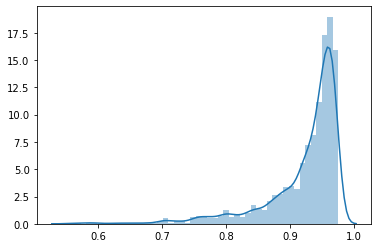

In [137]:
import seaborn as sns

def convert_proba_to_class(probability, thereshold = 0.8):
    return np.where(probability < thereshold, 1, 0)[:,0]

sns.distplot(LGBM_optuna_predicted_test[:, 0])

In [138]:
roc_auc_score(train_target, LGBM_predicted_train[:, 1])

0.9297474238294509

In [139]:
roc_auc_score(test_target, LGBM_predicted_test[:, 1])

0.7202028149313751

In [140]:
roc_auc_score(train_target, LGBM_optuna_predicted_train[:, 1])

0.9169218772692423

In [141]:
roc_auc_score(test_target, LGBM_optuna_predicted_test[:, 1])

0.7198601276335344

In [142]:
LGBM_predicted_train = LGBM_predicted_train[:, 1]
LGBM_predicted_test = LGBM_predicted_test[:, 1]
LGBM_optuna_predicted_train = LGBM_optuna_predicted_train[:, 1]
LGBM_optuna_predicted_test = LGBM_optuna_predicted_test[:, 1]

In [143]:
first_level_output = pd.DataFrame(data=np.array([LGBM_predicted_train, LGBM_optuna_predicted_train]).reshape(len(LGBM_predicted_train), 2), columns=['LGBM', 'LGBM_optuna'])
first_level_output = first_level_output.join(train_full_features.reset_index(drop=True))
first_level_output

,LGBM,LGBM_optuna,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,...,129,130,131,132,133,134,135,136,137,138
0,0.221159,0.092567,315992,0,180000.0,545040.0,25537.5,450000.0,0.003069,-2344.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0.027759,0.026853,284326,1,130500.0,900000.0,38133.0,900000.0,0.003069,-5122.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.144896,0.055389,155276,0,382500.0,1532565.0,65061.0,1323000.0,0.020713,-10348.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,0.046852,0.154463,419231,0,85500.0,1288350.0,37800.0,1125000.0,0.003813,-4109.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0.245430,0.035765,289793,0,67500.0,659610.0,25686.0,472500.0,0.020246,-881.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,0.044912,0.060379,395317,0,180000.0,227520.0,8707.5,180000.0,0.018801,-859.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
7996,0.042270,0.039493,287864,0,202500.0,270000.0,13500.0,270000.0,0.028663,-2184.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
7997,0.058817,0.049940,101371,1,315000.0,1024636.5,33993.0,918000.0,0.035792,-6085.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
7998,0.103143,0.130303,275047,1,120339.0,1035000.0,28593.0,1035000.0,0.030755,-3982.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [144]:
first_level_output_test = pd.DataFrame(data=np.array([LGBM_predicted_test, LGBM_optuna_predicted_test]).reshape(len(LGBM_predicted_test), 2), columns=['LGBM_test', 'LGBM_optuna_test'])
first_level_output_test = first_level_output_test.join(test_full_features.reset_index(drop=True))
first_level_output_test

,LGBM_test,LGBM_optuna_test,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,...,129,130,131,132,133,134,135,136,137,138
0,0.031363,0.069390,302666,0,45000.0,133528.5,9495.0,121500.0,0.026392,-10186.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0.035949,0.060294,406978,0,256500.0,1288350.0,41692.5,1125000.0,0.008575,-7101.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.081944,0.030554,286663,2,112500.0,295776.0,17109.0,234000.0,0.018850,-1806.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,0.085106,0.091834,418961,1,48600.0,918468.0,30352.5,697500.0,0.008019,-6892.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0.218356,0.031099,354514,2,67500.0,225000.0,10620.0,225000.0,0.018850,-9319.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.053308,0.043025,137502,1,135000.0,584766.0,24903.0,472500.0,0.004849,-7013.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1996,0.051873,0.201082,254841,0,225000.0,956574.0,43357.5,855000.0,0.008866,-974.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1997,0.078780,0.084575,341015,0,112500.0,364896.0,25524.0,315000.0,0.035792,-10655.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1998,0.096249,0.064213,137328,1,157500.0,1288350.0,37669.5,1125000.0,0.031329,-718.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


#### Second Level

In [145]:
lgbc=LGBMClassifier(**default_params)
lgbc.fit(first_level_output, train_target, eval_set=(first_level_output_test, test_target), eval_metric = 'auc')
predicted_train = lgbc.predict_proba(first_level_output)
predicted_test = lgbc.predict_proba(first_level_output_test)

/home/magleb/.local/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/magleb/.local/lib/python3.8/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's auc: 0.640019	valid_0's binary_logloss: 0.27238
Training until validation scores don't improve for 200 rounds
[2]	valid_0's auc: 0.679509	valid_0's binary_logloss: 0.272041
[3]	valid_0's auc: 0.68393	valid_0's binary_logloss: 0.271607
[4]	valid_0's auc: 0.69305	valid_0's binary_logloss: 0.271236
[5]	valid_0's auc: 0.694847	valid_0's binary_logloss: 0.270767
[6]	valid_0's auc: 0.697299	valid_0's binary_logloss: 0.270513
[7]	valid_0's auc: 0.702103	valid_0's binary_logloss: 0.270059
[8]	valid_0's auc: 0.702255	valid_0's binary_logloss: 0.269659
[9]	valid_0's auc: 0.702759	valid_0's binary_logloss: 0.269247
[10]	valid_0's auc: 0.698035	valid_0's binary_logloss: 0.269001
[11]	valid_0's auc: 0.697783	valid_0's binary_logloss: 0.268754
[12]	valid_0's auc: 0.699084	valid_0's binary_logloss: 0.26839
[13]	valid_0's auc: 0.698552	valid_0's binary_logloss: 0.268033
[14]	valid_0's auc: 0.700888	valid_0's binary_logloss: 0.267895
[15]	valid_0's auc: 0.700024	valid_0's binary_logloss: 

In [146]:
roc_auc_score(test_target.values, predicted_test[:, 1])

0.7175872016784683

In [147]:
roc_auc_score(train_target.values, predicted_train[:, 1])

0.960137750397698